# Mag-7 Concentration Analysis
<p style="color:darkblue; "><b>A TurningBull Notebook</b>

This notebook analyzes the concentration of the *'Mag-7'* stocks in the S&P 500 and their impact on the index.
The Mag-7 is comprised of Alphabet (Google), Apple, Amazon, Meta, Microsoft, Nvidia, and Tesla.  As we'll see, these technology stocks carry an outsized weight on the **S&P 500** stock index that represents the largest U.S. publicly traded companies by market capitalization.

In [77]:
## Import the necessary libraries
import os                           # For file operations
import numpy as np                  # For numerical operations
import pandas as pd                 # For data manipulation
import matplotlib.pyplot as plt     # For visualization
from urllib.request import urlopen  # For fetching data from the web
import json                         # For reading / writing JSON files

For this analysis we'll look at market caps and price action for the index and the mag-7s since 2015.  It's important to note that the Mag-7 term was coined in 2023.  Previously there was a similar group of stocks called the *FANG's*, or *FAANG's* dating back to 2013 and 2017, respectively.  Since the Mag-7 are what's in the news at the moment, we are focusing on them.

In [78]:
## parameters
start_date = '2015-01-01'               # Start date for the analysis 
end_date = '2024-12-31'                 # End date for the analysis
sp500_symbol = '^GSPC'                  # S&P 500 index symbol
mag7_symbols = ['GOOG','AMZN','AAPL','META','MSFT','NVDA','TSLA']   # Magnificent 7 symbols
api_key = os.environ['FMP_KEY']         # FMP market data API key

### Obtaining the Data

**FMP** offers a convenient api to retrieve the data we need - namely historical prices, S&P 500 historical constituents, and historical market caps.  To reduce boilerplating, we use a function to make the api call.

Since we'll pull price history for multiple stocks and the index, we define wrap the fmp func with one that takes only the symbol (ticker) as an argument.

In [79]:
## function to get data from api.
def get_fmp_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return pd.DataFrame(json.loads(data))

## get price history.
def get_price_history(ticker):
    url = f"https://financialmodelingprep.com/stable/historical-price-eod/full?symbol={ticker}&from={start_date}&to={end_date}&apikey={api_key}"
    return get_fmp_data(url)
sppa = get_price_history(sp500_symbol) ## S&P 500 price action

## get S&P 500 constituents.
url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={api_key}"
spc = get_fmp_data(url) ## current S&P 500 constituents

## get historical S&P 500 constituents.
url = f"https://financialmodelingprep.com/api/v3/historical/sp500_constituent?apikey={api_key}"
sphc = get_fmp_data(url) ## historical additions and removals

### Processing the Data

Data processing is the most involved phase of this analysis.  Starting with price action, the data sets received from FMP are daily OHLCV (open, high, low, close, volume).  We want to compute daily returns from the close prices and transform the data to monthly frequency.  For the Mag-7's we'll combine them into a single data set using *pd.concat*.

In [80]:
## process price data
def process_price_history(df):
    return (
        df                                                          # starting data frame
        .loc[:, ['date', 'close']]                                  # select date and close columns
        .assign(date = lambda x: pd.to_datetime(x.date))            # convert date to datetime
        .set_index('date')                                          # set date as index
        .sort_index(ascending=True)                                 # sort by date (oldest first)
        .assign(pctchg = lambda x: x.close.pct_change())            # calculate daily percentage change
        .dropna()                                                   # drop rows with missing values (first row)
        .resample('ME')                                             # resample by month end
        .agg({'close': 'last',                                      # get the last close price in the month
            'pctchg': lambda x: (1 + x).prod() - 1})                # calculate the monthly percentage change
        .reset_index()                                              # reset the index
        .assign(month = lambda df_: df_.date.dt.to_period('M'))     # extract the month
        .set_index('month')                                         # set the month as index
    )

sp500 = process_price_history(sppa)                                 # S&P 500 price action
mag7 = pd.concat([process_price_history(get_price_history(ticker)).loc[:,['pctchg']].rename(columns={'pctchg':ticker}) \
                  for ticker in mag7_symbols], axis=1)              # Magnificent 7 price action

Getting the S&P 500 constituents is a little more involved.  The FMP data is formatted as follows: The current constituents are essentially a list of stock tickers, while the historical data set is a change log of the additions and removals over time.  
The approach we're taking is to start with the most current list of stocks in the index, and then work backwards one month at at time using the historical changes.  Anchoring on beginning of month dates, each record in our data set will represent the S&P 500 membership as of the beginning of each month dating back to 2015.  That means any stocks that were added to the index intra-month are reflected in the next month's record, and stocks that were removed intra-month are part of the current month's record.  

In [81]:
def get_sp500_constituents():
    ## start with the current constituents and work backwards to build monthly snapshots of the S&P 500 constituents.
    sp500_constituents = {sp500.index[-1]: set(spc.symbol)}         # start with the current constituents

    ## get the monthly changes in the S&P 500 constituents
    sp500_changes = \
    (
        sphc
        .loc[:, ['date', 'symbol', 'removedTicker']]
        .assign(month = lambda df_: pd.to_datetime(df_.date).dt.to_period('M'),
                symbol = lambda df_: df_.symbol.mask(df_.symbol.eq(df_.removedTicker), None))
        .groupby('month')
        .agg({'symbol': set, 'removedTicker': set})
        .sort_index(ascending=False)
        .rename(columns={'symbol': 'added', 'removedTicker': 'removed'})
    )

    month_i = sp500.index[-1]                                   # start with the current month (last month in index)
    symbolsToRemove = sp500_changes.loc[month_i, 'added']       # get the symbols to remove
    symbolsToAdd = sp500_changes.loc[month_i, 'removed']        # get the symbols to add
    constituents_i = sp500_constituents[month_i].copy()         # make a copy to isolate changes to month[i]         
    constituents_i.difference_update(symbolsToRemove)
    constituents_i.update(symbolsToAdd)

    for month_i in sp500.index[-1::-1]:                         # iterate over the months in reverse order
        if month_i in sp500_changes.index:                      # follow the approach from above each month
            symbolsToRemove = sp500_changes.loc[month_i, 'added']
            if symbolsToRemove:
                constituents_i.difference_update(symbolsToRemove.copy())
            symbolsToAdd = sp500_changes.loc[month_i, 'removed']
            if symbolsToAdd:
                constituents_i.update(symbolsToAdd.copy())
            constituents_i.discard('')

        sp500_constituents[month_i] = constituents_i.copy()
    return sp500_constituents

sp500_constituents = get_sp500_constituents()

Obtaining market cap info is also an involved process, mainly due to the number of api calls required.  To estimate the index market cap for every month in our analysis, we have to source all of the market caps of the stocks that comprised the index in each month.  Further, there is a cap on the number of records retrieved from each api call, so we'll have to make two calls per stock to cover the full 10 years.
The algorithm we'll follow is:
1. Create a list (set) of all member stocks over the last 10 years.
2. For each stock, download the available market cap history.
3. For each month in the analysis, sum the market caps of all stocks that were index constituents as of the beginning of the month.

In [82]:
## Function to download market cap data.  This is called within the run routine..
def get_market_cap(ticker, start_date, end_date):
    url = f"https://financialmodelingprep.com/api/v3/historical-market-capitalization/{ticker}?limit=1500&from={start_date}&to={end_date}&apikey={api_key}"
    try:
        return (get_fmp_data(url)
            .loc[:, ['date', 'marketCap']]                                  # Extract the market cap data.
            .assign(date = lambda x: pd.to_datetime(x.date))                # Convert the date to a datetime object.
            .set_index('date')                                              # Index on date.
            .sort_index(ascending=True)                                     # Sort the dataset by date.
            .assign(marketCap = lambda x: x.marketCap.div(1e9))             # Scale market cap to billions.
            .resample('ME')                                                 # Adjust periodicity to monthly.
            .agg({'marketCap': 'first'})                                    # Use the beginning value.
            .reset_index()
            .assign(month = lambda df_: df_.date.dt.to_period('M'))
            .set_index('month')                                             # Reindex to month.
            .loc[:, ['marketCap']]
        )
    except:
        return None

## Main routine 
def run_market_caps():
    ## get the full set of symbols to pull data for.
    all_symbols = set(sp500_constituents[sp500.index[-1]])
    for month, symbols in sp500_constituents.items():
        all_symbols.update(symbols)

    market_caps = dict(zip(sp500.index, [dict() for _ in range(len(sp500))]))   # Create a dictionary by month for each constituent stock.
    for symbol in sorted(list(all_symbols)):
        for start_date, end_date in [('2015-01-01', '2019-12-31'), ('2020-01-01', '2024-12-31')]:  # Split the api call across two date ranges.
            market_cap = get_market_cap(symbol, start_date, end_date)
            print (symbol, market_cap.size if market_cap is not None else 0)
            if market_cap is not None:
                for month, cap in market_cap.iterrows():
                    market_caps[month][symbol] = cap.marketCap
    return market_caps
    
## function to save market caps to json file
def save_market_caps(market_caps):
    pd.DataFrame(market_caps).to_json('sp500_market_caps.json', orient='index')

## function to load market caps from json file
def load_market_caps(fname):
    return pd.read_json(fname, orient='index')

To avoid running the market caps routine each time, we can save the dataset to a *json* file.  Going forward, we just load the dataset from our local store.
Unfortunately, data is rarely clean, and the market caps dataset is no exception.  There are a few stocks that need to be dropped to avoid double counting the total S&P 500 market cap.  This is mainly a result of multiple share classes for some stocks, such as **Google (GOOG & GOOGL).**  

In [83]:
market_caps = \
(
    load_market_caps('../var/sp500_market_caps.json').T                         # Read from file.
    .assign(month = lambda df_: pd.to_datetime(df_.index).to_period('M'))       # Do some pre-processing.
    .reset_index(drop=True)
    .set_index('month')
    .drop(['GOOGL', 'NWSA','FOXA', 'WBD'], axis=1)                              # Drop duplicate symbols, as described above.
)

## Compute S&P market cap 
sp500 = \
(
    sp500
    .assign(marketCap = lambda df_: df_.index.map(
        lambda x: market_caps.loc[x, [i for i in sp500_constituents[x] if i in market_caps.loc[x]]].sum()))
)

## Mag-7 marketcaps 
mag7_market_caps = \
(
    market_caps.loc[:,mag7_symbols]
    .assign(**dict(zip(mag7_symbols, [market_caps.index.map(
        lambda x: market_caps.loc[x, i] if i in sp500_constituents[x] else 0) for i in mag7_symbols]
    )))
    .assign(Total = lambda df_: df_.loc[:,mag7_symbols].sum(axis=1))
    
)

In [84]:
## Test for duplicate symbols (overstating market cap)
## The function looks for symbols that have the same total market cap data.
def test_dupe_mktcaps(market_caps):
    return (
        market_caps
        .sum(axis=0)
        .round(2)
        .reset_index()
        .rename(columns={'index':'symbol', 0:'mc'})
        .loc[:, ['mc', 'symbol']]
        .groupby('mc')
        .agg({'symbol': list})
        .where(lambda df_: df_.symbol.map(len) > 1).dropna()
    )

For this analysis, we're going to be interested understanding how the Mag-7 stocks impact the overall index.  Thus, we'll need to compute their *index weights* through time.  These weights will represent their weight in relation to the overall index.  We'll also want to look at Mag-7 performance.  In doing this we'll need to compute their absolute weights as if they represent a separate portfolio:

In [85]:
## Mag-7 weights relative to the S&P 500..
mag7_weights = \
(
    mag7_market_caps
    .div(sp500.marketCap, axis=0)
)

## Mag-7 absolute weights (market cap / total Mag-7 market cap)
mag7_abs_weights = mag7_market_caps.loc[:,mag7_symbols].div(mag7_market_caps.Total, axis=0)

There are a number of return calculations we need to view performance impact from a few perspectives:
1. S&P 500 monthly returns.
2. Mag-7 monthly returns (using relative weights).
3. Mag-7 monthly returns (using absolute weights).
4. S&P 500 cumulative return.
5. Mag-7 cumulative return.
6. S&P 500 cumulative return excluding Mag-7s.
7. Mag-7 performance contribution to S&P 500.
8. S&P 500 rolling 1-yr returns.
9. Mag-7 rolling 1-yr returns.

In [86]:
## Compute return contribution
return_contributions = \
(
    sp500
    .loc[:,['pctchg']]
    .rename(columns={'pctchg':'sp500'})                                                         # (1)
    .join(mag7.mul(mag7_weights.loc[:,mag7_symbols]).sum(axis=1).rename('mag7'))                # (2)
    .join(mag7_weights.loc[:,['Total']].rename(columns={'Total':'mag7_weight'}))                # mag-7 total relative weights.
    .join(mag7.mul(mag7_abs_weights.loc[:,mag7_symbols]).sum(axis=1).rename('mag7_abs'))        # (3)
    .assign(ex_mag7_weight = lambda df_: 1 - df_.mag7_weight,                                   
            ex_mag7 = lambda df_: df_.sp500.sub(df_.mag7).div(df_.ex_mag7_weight),              # (6) monthly returns ex-mag-7.
            sp500_cr = lambda df_: (1 + df_.sp500).cumprod() - 1,                               # (4)
            mag7_cr = lambda df_: (1 + df_.mag7).cumprod() - 1,                                 # (5)
            ex_mag7_cr = lambda df_: (1 + df_.ex_mag7).cumprod() - 1,                           # (6)
            mag7_pa = lambda df_: df_.mag7.div(df_.sp500).mul(100),                             # (7)
            sp500_1y = lambda df_: df_.sp500.rolling(window=12).apply(lambda x: ((1 + x).cumprod()-1).iloc[-1], raw=False),   # (8)
            mag7_1y = lambda df_: df_.mag7_abs.rolling(window=12).apply(lambda x: ((1 + x).cumprod()-1).iloc[-1], raw=False)) # (9)
)

### Visualize the Data

With our pre-processing and returns calculations out of the way, we now turn our attention to producing a set of plots to help us tell our story about Mag-7 impact on the S&P 500.  The main themes we'll study are:
1. Comparing S&P performance with, and without (excluding) the Mag-7s.
2. Rolling 1-yr comparison of the S&P and the Mag-7s.
3. Performance attribution of the Mag-7s to S&P monthly returns.
4. Market cap growth the the S&P and the Mag-7s over time.

For each of these plots, we create a function that allows us to either display the plot with this notebook or save the figure as a *.png* file.

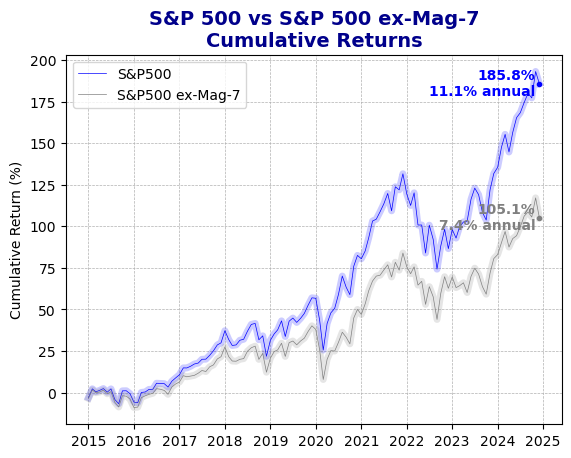

In [135]:
## Plot the S&P cumulative return and the S&P ex-Mag-7 cumulative return
def plot_mag7_1(fname=None):
    fig, ax1 = plt.subplots()

    sp500_cr = return_contributions.sp500_cr.mul(100) 
    sp500_an = return_contributions.sp500.add(1).cumprod().pow(12./return_contributions.index.size).mul(100).iloc[-1] - 100
    exmag7_cr = return_contributions.ex_mag7_cr.mul(100)
    exmag7_an = return_contributions.ex_mag7.add(1).cumprod().pow(12./return_contributions.index.size).mul(100).iloc[-1] - 100

    ## Plot the cumulative returns
    ax1.plot(sp500_cr.index.to_timestamp(), sp500_cr, linewidth=5, alpha=0.2, color='blue')
    ax1.plot(sp500_cr.index.to_timestamp(), sp500_cr, label='S&P500', linewidth=0.5, color='blue')
    ax1.plot(exmag7_cr.index.to_timestamp(), exmag7_cr, linewidth=5, alpha=0.2, color='grey')
    ax1.plot(exmag7_cr.index.to_timestamp(), exmag7_cr, label='S&P500 ex-Mag-7', linewidth=0.5, color='grey')

    ## Plot the end points and text
    ax1.plot(sp500_cr.index.to_timestamp()[-1], sp500_cr.iloc[-1], 'o', markersize=3, color='blue')
    ax1.text(sp500_cr.index.to_timestamp()[-2], sp500_cr.iloc[-1], f"{sp500_cr.iloc[-1]:.1f}%\n{sp500_an:.1f}% annual", \
             color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
    ax1.plot(exmag7_cr.index.to_timestamp()[-1], exmag7_cr.iloc[-1], 'o', markersize=3, color='grey')
    ax1.text(exmag7_cr.index.to_timestamp()[-2], exmag7_cr.iloc[-1], f"{exmag7_cr.iloc[-1]:.1f}%\n{exmag7_an.round(1):.1f}% annual", \
             color='grey', fontsize=10, ha='right', va='center', fontweight='bold')

    ax1.set_title("S&P 500 vs S&P 500 ex-Mag-7\nCumulative Returns", fontweight='bold', fontsize=14, color='darkblue')
    ax1.set_ylabel('Cumulative Return (%)')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.legend()

    if fname:
        plt.savefig(fname, format='jpg', dpi=300)
    else:
        plt.show()

plot_mag7_1()


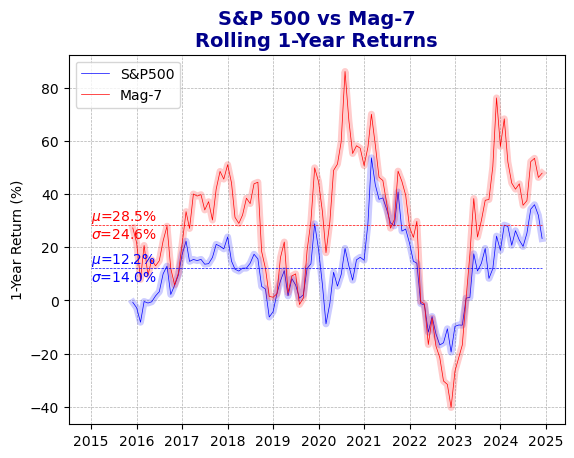

In [136]:
## Plot the S&P 500 rolling 1-year return and the Mag-7 rolling 1-year return
def plot_mag7_2(fname=None):
    fig, ax2 = plt.subplots()
    sp500_1y = return_contributions.sp500_1y.mul(100)
    sp500_mu = sp500_1y.mean()
    sp500_sd = sp500_1y.std()
    mag7_1y = return_contributions.mag7_1y.mul(100)
    mag7_mu = mag7_1y.mean()
    mag7_sd = mag7_1y.std()

    ## Plot the rolling 1-year returns
    ax2.plot(sp500_1y.index.to_timestamp(), sp500_1y, linewidth=5, alpha=0.2, color='blue')
    ax2.plot(sp500_1y.index.to_timestamp(), sp500_1y, label='S&P500', linewidth=0.5, color='blue')
    ax2.plot(mag7_1y.index.to_timestamp(), mag7_1y, linewidth=5, alpha=0.2, color='red')
    ax2.plot(mag7_1y.index.to_timestamp(), mag7_1y, label='Mag-7', linewidth=0.5, color='red')

    ## Plot the mean and standard deviation
    ax2.hlines(sp500_mu, sp500_1y.index.to_timestamp()[0], sp500_1y.index.to_timestamp()[-1], linestyles='--', linewidth=0.5, color='blue')
    ax2.hlines(mag7_mu, mag7_1y.index.to_timestamp()[0], mag7_1y.index.to_timestamp()[-1], linestyles='--', linewidth=0.5, color='red')

    ax2.text(sp500_1y.index.to_timestamp()[0], sp500_mu, f"$\\mu$={sp500_mu:.1f}%\n$\\sigma$={sp500_sd:.1f}%", \
             color='blue', fontsize=10, ha='left', va='center')
    ax2.text(mag7_1y.index.to_timestamp()[0], mag7_mu, f"$\\mu$={mag7_mu:.1f}%\n$\\sigma$={mag7_sd:.1f}%", \
             color='red', fontsize=10, ha='left', va='center')
    
    ax2.set_title("S&P 500 vs Mag-7\nRolling 1-Year Returns", fontweight='bold', fontsize=14, color='darkblue')
    ax2.set_ylabel('1-Year Return (%)')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax2.legend()
    
    if fname:
        plt.savefig(fname, format='jpg', dpi=300)
    else:   
        plt.show()

plot_mag7_2()

In [104]:
## Capture ratio function
def upside_capture_ratio(df):
    return (
        df
        .assign(up = lambda df_: df_.sp500.gt(0))
        .groupby('up')
        .agg({'sp500': lambda x: (1 + x).prod() - 1,
              'mag7_abs': lambda x: (1 + x).prod() - 1})
        .assign(ucr = lambda df_: df_.mag7_abs.div(df_.sp500).mul(100))
        .loc[True, 'ucr']
    )

def downside_capture_ratio(df):
    return (
        df
        .assign(down = lambda df_: df_.sp500.lt(0))
        .groupby('down')
        .agg({'sp500': lambda x: (1 + x).prod() - 1,
              'mag7_abs': lambda x: (1 + x).prod() - 1})
        .assign(dcr = lambda df_: df_.mag7_abs.div(df_.sp500).mul(100))
        .loc[True, 'dcr']
    )

def capture_ratio(df):
    return (
        upside_capture_ratio(df) / downside_capture_ratio(df)
    )


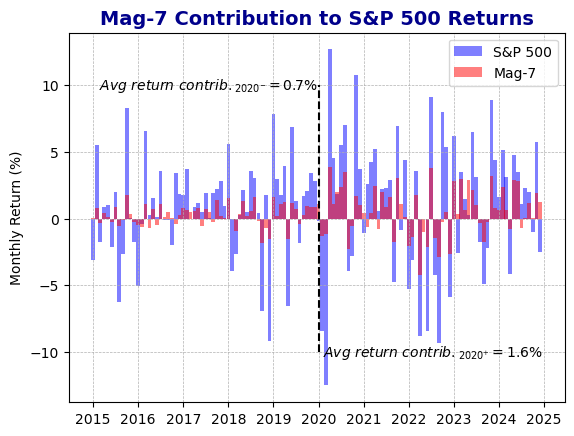

In [137]:
## Plot Mag-7 contribution to S&P 500 returns
def plot_mag7_3(fname=None):
    fig, ax3 = plt.subplots()

    sp500_mr = return_contributions.sp500.mul(100)
    mag7_mr = return_contributions.mag7.mul(100)

    cpr1 = return_contributions.loc[:'2019-12'].mag7.abs().mean() * 100
    cpr2 = return_contributions.loc['2020-01':].mag7.abs().mean() * 100

    width = pd.Timedelta(30, 'd')
    ax3.bar(sp500_mr.index.to_timestamp(), sp500_mr, width=width, label='S&P 500', color='blue',alpha=0.5)
    ax3.bar(mag7_mr.index.to_timestamp(), mag7_mr, width=width, label='Mag-7', color='red',alpha=0.5)

    ii = sp500_mr.loc['2020-01':].index[0].to_timestamp()
    ax3.vlines(ii, -10, 10, linestyles='--', linewidth=1.5, color='black')
    ax3.text(ii, 10, f"$Avg\\ return\\ contrib._{{2020^{{-}}}} = {cpr1:.1f}$% ", \
             color='black', fontsize=10, ha='right', va='center')
    ax3.text(ii, -10, f" $Avg\\ return\\ contrib._{{2020^{{+}}}} = {cpr2:.1f}$%", \
             color='black', fontsize=10, ha='left', va='center')

    ax3.set_title("Mag-7 Contribution to S&P 500 Returns", fontweight='bold', fontsize=14, color='darkblue')
    ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax3.set_ylabel('Monthly Return (%)')
    ax3.legend()

    if fname:
        plt.savefig(fname, format='jpg', dpi=300)
    else:       
        plt.show()

plot_mag7_3()

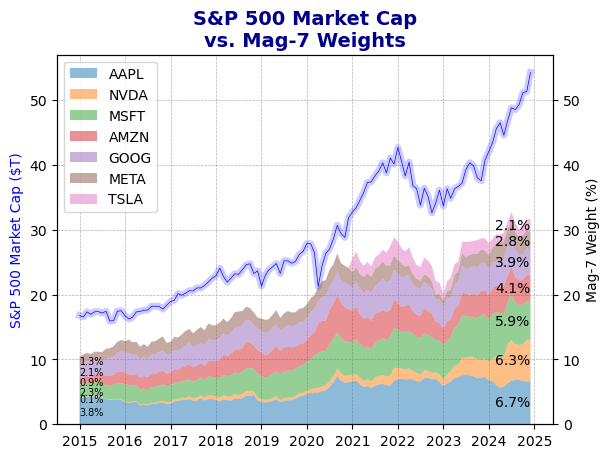

In [133]:
## Plot the market cap weights over time
def plot_mag7_4(fname=None):
    fig, ax4 = plt.subplots()

    sp500_mc = sp500.marketCap.div(1e3)

    ax4.plot(sp500_mc.index.to_timestamp(), sp500_mc, label='S&P 500', linewidth=5, alpha=0.2, color='blue')
    ax4.plot(sp500_mc.index.to_timestamp(), sp500_mc, label='S&P 500', linewidth=0.5, color='blue')

    ax4.set_title("S&P 500 Market Cap\nvs. Mag-7 Weights", fontweight='bold', fontsize=14, color='darkblue')
    ax4.set_ylabel('S&P 500 Market Cap ($T)', color='blue')
    ax4.set_ylim(0, 57)
    ax4.grid(True, which='both', linestyle='--', linewidth=0.5)

    ax5 = ax4.twinx()

    mag7_ordered = mag7_weights.loc[:, mag7_weights.iloc[-1].sort_values(ascending=False).index].mul(100)
    cum_weights = mag7_ordered.iloc[:, 1]
    
    ax5.fill_between(cum_weights.index.to_timestamp(), cum_weights, label=mag7_ordered.columns[1], alpha=0.5)
    
    ax5.text(cum_weights.index.to_timestamp()[0], cum_weights.iloc[0]/2, f"{cum_weights.iloc[0]:.1f}%", ha='left', va='center', fontsize=7)

    ax5.text(cum_weights.index.to_timestamp()[-1], cum_weights.iloc[-1]/2, f"{cum_weights.iloc[-1]:.1f}%", ha='right', va='center', fontsize=10)

    for i in range(2, len(mag7_ordered.columns)):
        ax5.fill_between(mag7_ordered.index.to_timestamp(), cum_weights.values, cum_weights.add(mag7_ordered.iloc[:,i]), label=mag7_ordered.columns[i], alpha=0.5)
        
        if i != 7:
            ax5.text(mag7_ordered.index.to_timestamp()[0], (cum_weights.iloc[0] + cum_weights.iloc[0] + \
                mag7_ordered.iloc[0,i])/2, f"{mag7_ordered.iloc[0,i]:.1f}%", ha='left', va='center', fontsize=7)

        ax5.text(mag7_ordered.index.to_timestamp()[-1], (cum_weights.iloc[-1] + cum_weights.iloc[-1] + \
            mag7_ordered.iloc[-1,i])/2, f"{mag7_ordered.iloc[-1,i]:.1f}%", ha='right', va='center', fontsize=10)
        
        cum_weights = cum_weights.add(mag7_ordered.iloc[:,i])

    ax5.set_ylim(0, ax4.get_ylim()[1])
    ax5.set_ylabel('Mag-7 Weight (%)')
    ax5.legend(loc='upper left')
    
    if fname:
        plt.savefig(fname, format='jpg', dpi=300)
    else:
        plt.show()

plot_mag7_4()